In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/[2024-2025] AN2DL HOMEWORK 1

Mounted at /gdrive
/gdrive/.shortcut-targets-by-id/117Cy5jmRvw7kUjsl1Y2WzOeI_SAmudjh/[2024-2025] AN2DL HOMEWORK 1


In [ ]:
# Fix randomness and hide warnings
SEED = 42  # Random seed for reproducibility

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(SEED)
random.seed(SEED)

# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from tensorflow.keras import metrics
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import (Input, Concatenate, Dense, GlobalAveragePooling2D,
                                     Dropout, RandomFlip, RandomRotation, RandomZoom,
                                     RandomContrast, RandomBrightness)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adadelta
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# Set seed for TensorFlow
tf.random.set_seed(SEED)
tf.compat.v1.set_random_seed(SEED)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Print TensorFlow version
print(tf.__version__)

# Import other libraries
# Import other libraries
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns
from PIL import Image
import matplotlib.gridspec as gridspec
from datetime import datetime

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

2.17.1


In [ ]:
# Load data
data = np.load('training_set.npz')
X = data['images']
y = data['labels']

In [ ]:
print(X.shape)
print(y.shape)

(13759, 96, 96, 3)
(13759, 1)


In [ ]:
# Get unique labels and print statistics
unique_labels = np.unique(y)
print(f"Number of unique labels: {len(unique_labels)}")
for label in unique_labels:
    print(f"Number of images with label {label}: {len(np.where(y == label)[0])}")

Number of unique labels: 8
Number of images with label 0: 1052
Number of images with label 1: 2381
Number of images with label 2: 1285
Number of images with label 3: 2226
Number of images with label 4: 1049
Number of images with label 5: 1393
Number of images with label 6: 2530
Number of images with label 7: 1843


We notice the dataset is unbalanced.

# Exploratory Data Analysis

We use any pretrained model in order to generate a feature vector which is then projected in two dimension using tSNE. This should allow us to see whether there are any noticeable outliers.

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
430/430 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step


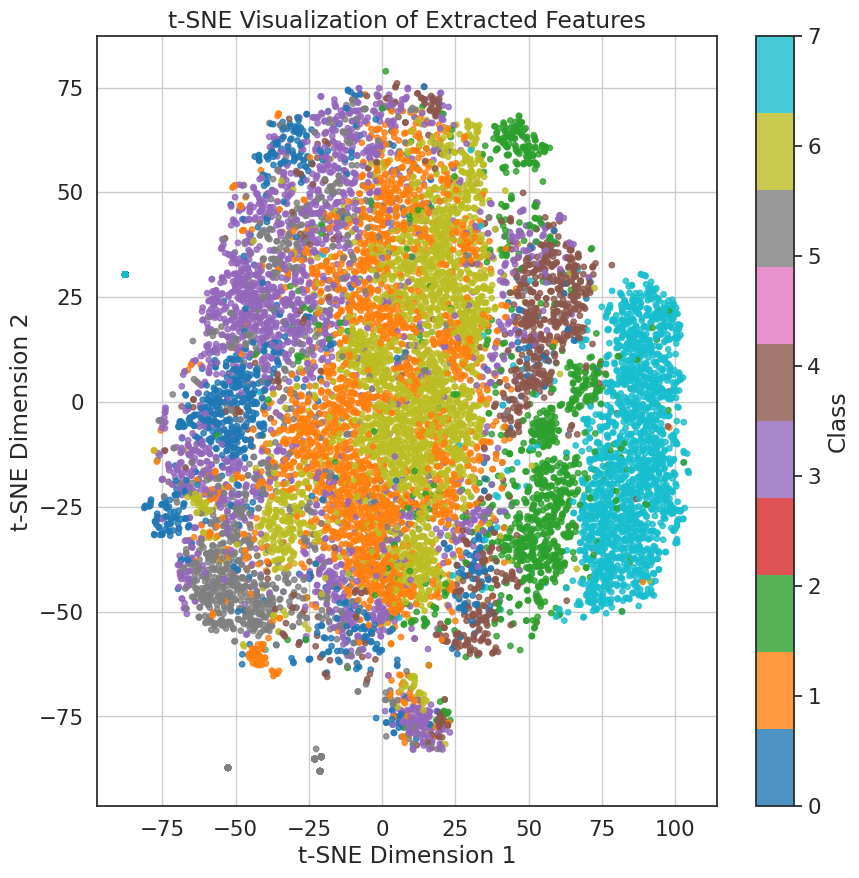

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from sklearn.manifold import TSNE

def extract_features_tf(X, model):
    """
    Extract feature vectors for a dataset using a pretrained TensorFlow model.

    Parameters:
        X (numpy array): Array of images (N, H, W, C).
        model (tf.keras.Model): Pretrained model for feature extraction.

    Returns:
        features (numpy array): Extracted feature vectors.
    """
    # Preprocess the images for the model
    X_preprocessed = preprocess_input(X)

    # Extract features
    features = model.predict(X_preprocessed, batch_size=32, verbose=1)

    return features

def plot_tsne(features, labels=None):
    """
    Reduce features to 2D using t-SNE and plot the results.

    Parameters:
        features (numpy array): High-dimensional feature vectors.
        labels (array-like): Labels corresponding to the features (optional).
    """
    tsne = TSNE(n_components=2, random_state=42)
    reduced_features = tsne.fit_transform(features)

    plt.figure(figsize=(10, 10))
    scatter = plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=labels, cmap='tab10', s=15, alpha=0.8)

    if labels is not None:
        plt.colorbar(scatter, label='Class')
    plt.title('t-SNE Visualization of Extracted Features')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.grid(True)
    plt.show()

    return reduced_features  # Return the 2D representation

# Load pretrained ResNet50 model (without top layer)
base_model = ResNet50(weights='imagenet', include_top=False, pooling='avg')

# Extract features
features = extract_features_tf(X, base_model)

# Plot t-SNE
reduced_features = plot_tsne(features, labels=y)

We notice there are evident outliers belonging to class 5.

In [ ]:
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider, fixed
import math

def display(X, y, images_per_page=100):
    """
    Display images from a dataset with an interactive slider.

    Parameters:
        X (np.ndarray): The dataset of images.
        y (np.ndarray): The labels corresponding to the dataset.
        images_per_page (int): Number of images to display per page (default: 9).
    """
    def show_images(start_index):
        """
        Display a grid of images starting from `start_index`.

        Parameters:
            start_index (int): The starting index of images to display.
        """
        end_index = min(start_index + images_per_page, len(X))
        num_images = end_index - start_index

        # Compute rows and columns dynamically
        num_cols = math.ceil(math.sqrt(num_images))  # Column count based on square root
        num_rows = math.ceil(num_images / num_cols)  # Row count to fit all images

        fig, axes = plt.subplots(num_rows, num_cols, figsize=(8, 8))
        axes = axes.flatten()

        for i, ax in enumerate(axes):
            img_index = start_index + i
            if img_index < end_index:
                ax.imshow(X[img_index])
                ax.set_title(f"Index: {img_index}\nLabel: {y[img_index]}", fontsize=10)
                ax.axis('off')
            else:
                ax.axis('off')  # Turn off unused subplots

        plt.tight_layout()
        plt.show()

    interact(
        show_images,
        start_index=IntSlider(
            min=0, max=len(X) - images_per_page, step=images_per_page, value=0,
            description="Start Index"
        )
    )

display(X, y)

interactive(children=(IntSlider(value=0, description='Start Index', max=13659, step=100), Output()), _dom_clas…

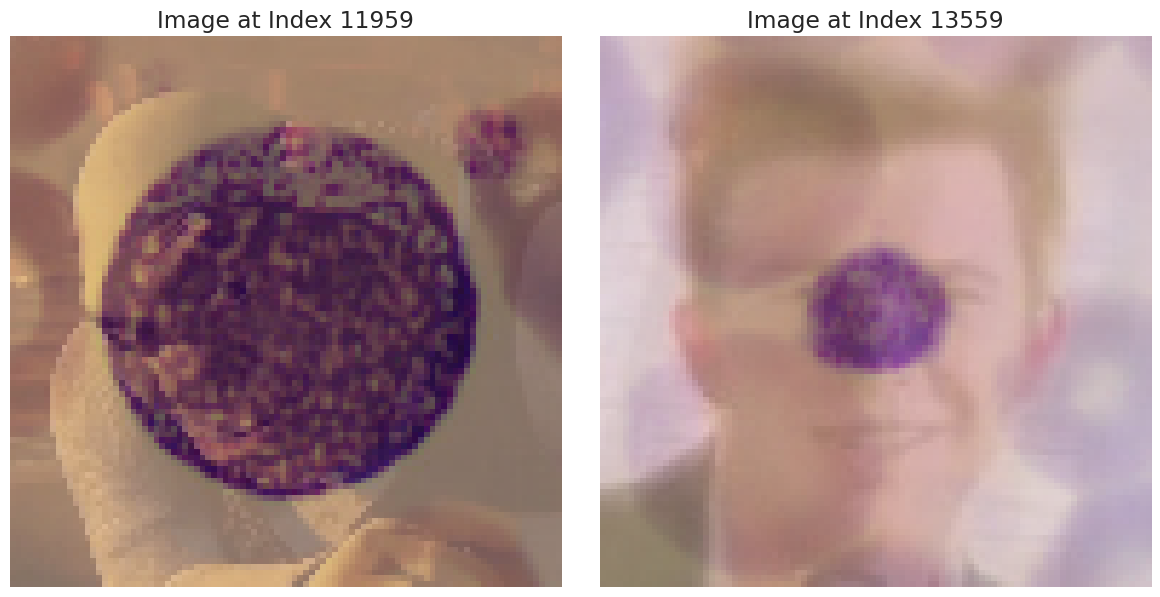

In [ ]:
# Indices of the images to display
idx1 = 11959
idx2 = 13559  # Adjust to the next index or any other index you want

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Display the first image
axes[0].imshow(X[idx1])
axes[0].set_title(f"Image at Index {idx1}")
axes[0].axis('off')  # Hide axes

# Display the second image
axes[1].imshow(X[idx2])
axes[1].set_title(f"Image at Index {idx2}")
axes[1].axis('off')  # Hide axes

# Show the plot
plt.tight_layout()
plt.show()


The outliers i.e. Shrek and Rick Roll are at the end of the dataset. The former affects all classes while the latter only class 5. We extract the indices that we'll later use to slice the dataset.

57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step


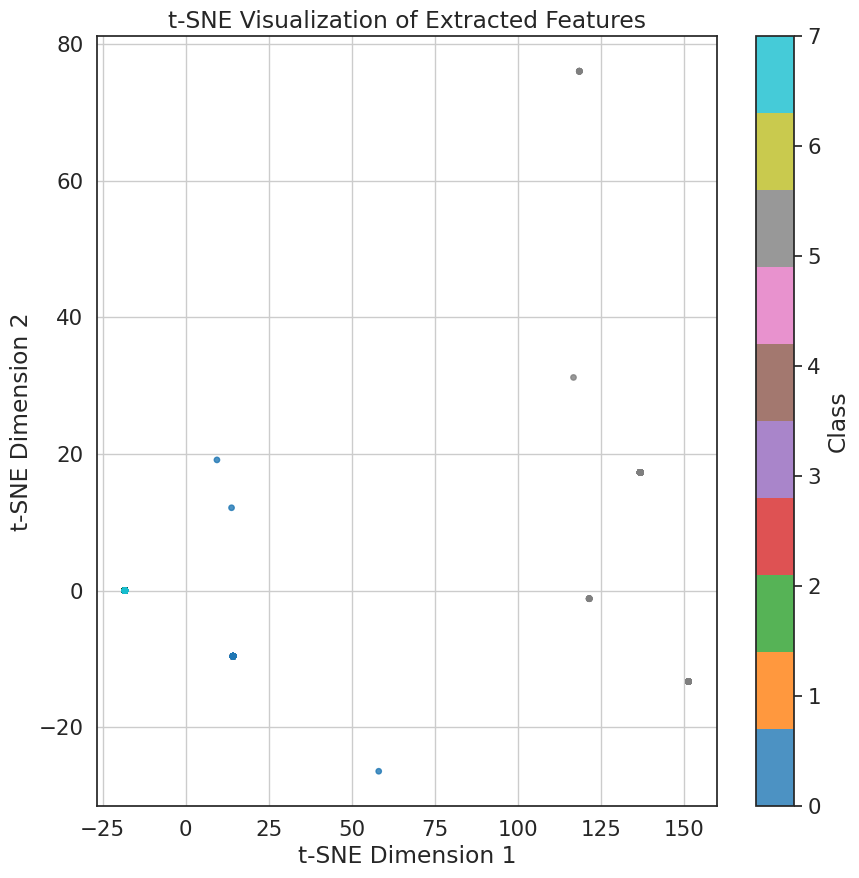

In [ ]:
# Select outliers
X_out = X[11960:]
y_out = y[11960:]

# Extract features and plot
features2 = extract_features_tf(X_out, base_model)
reduced_features = plot_tsne(features2, labels=y_out)

# Data Preprocessing

## Train-Validation-Test Split

We assumed that in real-world scenarios, white blood cell types are equally represented. To evaluate our model fairly, we used a balanced test set, ensuring that performance metrics (e.g. accuracy) reflect the model's ability to handle all classes, not just the dominant ones. The validation set is kept unbalanced not to further exaggerate the unbalance ratios.

In [ ]:
# Load data
data = np.load('training_set.npz')
X = data['images']
y = data['labels']

# Remove outliers
X = X[:11959]
y = y[:11959]

# Usa np.unique per trovare indici delle immagini uniche
_, unique_indices = np.unique(X.reshape(len(X), -1), axis=0, return_index=True)

# Estrai le immagini e le etichette corrispondenti agli indici unici
X = X[unique_indices]
y = y[unique_indices]

unique_classes = np.unique(y)
test_indices = []

#Define the number of instances per class that have to be added to the test set
samples_per_class = 70 # Less than 10% than the minimum represented class

# Sample equally from each class
for class_label in unique_classes:
    class_indices = np.where(y == class_label)[0]
    np.random.shuffle(class_indices)
    test_indices.extend(class_indices[:samples_per_class])

# Remove test indices from remaining dataset
test_indices = np.array(test_indices)
train_val_indices = np.setdiff1d(np.arange(len(X)), test_indices)

# Create splits
X_test, y_test = X[test_indices], y[test_indices]
X_train_val, y_train_val = X[train_val_indices], y[train_val_indices]

# Stratify ensures the class distribution is preserved
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.1, stratify=y_train_val, random_state=42
)

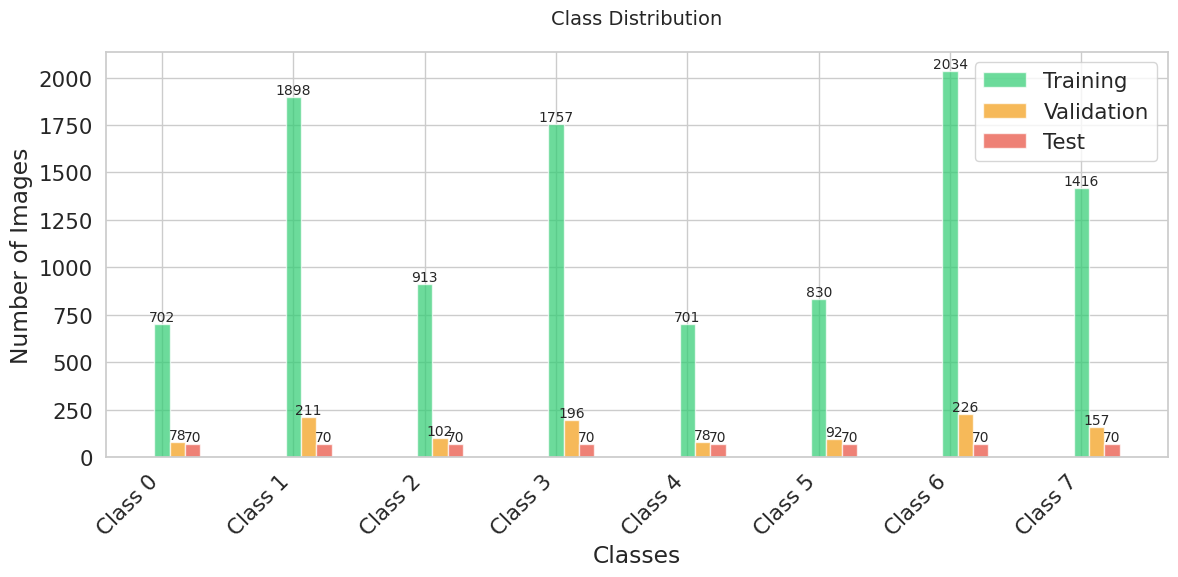

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def plot_class_distribution(y_vectors, class_names, dataset_names=None):
    """
    Plot class distribution for 2 or 3 datasets (e.g., train, val, test).

    Parameters:
    - y_vectors (list of 1D arrays): Class indices for each dataset.
    - class_names (list of str): Names of the classes.
    - dataset_names (list of str, optional): Names of the datasets. Defaults to ['Dataset 1', 'Dataset 2', ...].
    """
    if dataset_names is None:
        dataset_names = [f"Dataset {i+1}" for i in range(len(y_vectors))]

    # Ensure inputs are 1D arrays of integers
    y_vectors = [np.ravel(vec).astype(int) for vec in y_vectors]

    # Set seaborn style for the plot
    sns.set_style("whitegrid")
    plt.figure(figsize=(12, 6))

    # Calculate class distributions
    dists = [np.bincount(y, minlength=len(class_names)) for y in y_vectors]

    # Create x positions and set bar width
    x = np.arange(len(class_names))
    width = 0.35 / len(y_vectors)  # Adjust width based on the number of datasets

    # Plot bars for each distribution
    for i, (dist, name, color) in enumerate(zip(dists, dataset_names, ['#2ecc71', '#f39c12', '#e74c3c'][:len(y_vectors)])):
        bars = plt.bar(x + i * width, dist, width, label=name, color=color, alpha=0.7)

        # Add count annotations on top of the bars
        for bar in bars:
            yval = bar.get_height()
            plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.05,  # Offset above the bar
                     f'{int(yval)}', ha='center', va='bottom', fontsize=10)

    # Customise plot title and labels
    plt.title('Class Distribution', pad=20, fontsize=14)
    plt.xlabel('Classes')
    plt.ylabel('Number of Images')

    # Set class names as x-axis labels with rotation
    plt.xticks(x, class_names, rotation=45, ha='right')
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.show()

class_names = [f"Class {i}" for i in range(len(np.unique(y_train)))]
dataset_names = ['Training', 'Validation', 'Test']
plot_class_distribution([y_train, y_val, y_test], class_names, dataset_names)

## Unbalance Management


The generated splits present a strong class imbalance in validation and training. This could strongly impact the performances of the model. In order to solve this issue we analyzed and tested two different approaches



*   Rebalancing the validation and training dataset using synthetic data  generation
*   Using class weights and performing training time data augmentation during training

Since both methodology require data augmentation to be performed we firstly analyzed the kind of transformations that shouldn't have an impact on class attribution.
In order to do that we gathered information about the dataset subject:

*   Basophil
*   Eosinophil
*   Erythroblast
*   Immature granylocytes
*   Lymphocyte
*   Monocyte
*   Neutrophil
*   Platelet

All these cells can be photographed in different angles and directions, they present the same colors and have similar directions.
Some major appereance differences can however be identified in cell's proportion and shapes. Erythroblast and platelet for instance have noticeably different shapes from the other cells.
For this reasons we decided to apply transformations that alter color and spacial positioning but do not alter proportions and shape.
In particular we choosed:
  RandomFlip
  RandomRotation
  RandomContrast
  RandomBrightness
  RandomZoom

### Synthetic Data Creation

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Function to augment a single class
def augment_class(X, y, target_class, target_count):
    """
    Augment images for a specific class to reach the target count.

    Parameters:
        X (array-like): Array of images.
        y (array-like): Array of labels.
        target_class (int): The class to augment.
        target_count (int): The desired number of samples for the class.

    Returns:
        X_augmented (numpy.ndarray): Augmented images for the target class.
        y_augmented (numpy.ndarray): Labels for the augmented images.
    """
    # Flatten `y` to ensure compatibility
    y_flat = np.ravel(y)
    target_indices = np.where(y_flat == target_class)[0]
    X_target = X[target_indices]

    # Create an ImageDataGenerator for augmentation
    datagen = ImageDataGenerator(
        rotation_range=30,
        zoom_range=0.2,
        #contrast_range=[0.7, 1.3],
        brightness_range=[0.9, 1.1],
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # Calculate the number of samples to generate
    num_to_generate = target_count - len(target_indices)

    # Generate augmented images and labels
    augmented_images = []
    augmented_labels = []

    # Create batches of augmented images
    for X_batch, _ in zip(datagen.flow(X_target, batch_size=1, shuffle=True), range(num_to_generate)):
        img = np.clip(X_batch[0], 0, 255).astype(X.dtype)
        augmented_images.append(img)
        augmented_labels.append(target_class)

    X_augmented = np.array(augmented_images)
    y_augmented = np.array(augmented_labels).reshape(-1, 1)  # Ensure y_augmented has shape (N, 1)

    # Remove the extra batch dimension from the augmented images
    # X_augmented = np.squeeze(X_augmented, axis=1)

    return X_augmented, y_augmented

# Function to augment all classes and return the augmented data
def augment_all_classes(X, y, target_count):
    """
    Augment images for a specific class to reach the target count.

    Parameters:
        X (array-like): Array of images.
        y (array-like): Array of labels.
        target_class (int): The class to augment.
        target_count (int): The desired number of samples for the class.

    Returns:
        X_augmented (numpy.ndarray): Augmented images for the target class.
        y_augmented (numpy.ndarray): Labels for the augmented images.
    """
    # Ensure `y` is a 1D array of class indices
    y = np.ravel(y)  # Flatten y if it's a 2D array with one column

    # Count the number of occurrences of each class
    class_counts = np.bincount(y)  # Now y should be a 1D array of class indices

    # Initialize lists to hold augmented data
    X_augmented_all = []
    y_augmented_all = []

    # For each class, if the count is less than the target count, augment it
    for target_class in range(len(np.unique(y))):  # Use class indices directly
        if class_counts[target_class] < target_count:
            print(f"Class {target_class} has {class_counts[target_class]} samples. Augmenting to {target_count} samples.")
            X_augmented, y_augmented = augment_class(X, y, target_class, target_count)
            X_augmented_all.append(X_augmented)
            y_augmented_all.append(y_augmented)
        else:
            print(f"Class {target_class} already has {class_counts[target_class]} samples. No augmentation needed.")

    # Concatenate all augmented data
    if X_augmented_all:
        X_augmented_all = np.concatenate(X_augmented_all, axis=0)
        y_augmented_all = np.concatenate(y_augmented_all, axis=0)
    else:
        X_augmented_all = np.empty((0,) + X.shape[1:], dtype=X.dtype)
        y_augmented_all = np.empty((0, 1), dtype=y.dtype)  # Match (N, 1) shape

    return X_augmented_all, y_augmented_all

# Set target count for all classes to be 120% of the majority class count
TARGET_ON_MAJORITY = 1
class_counts = np.bincount(np.ravel(y_train))  # Flatten y_train if needed
majority_class_count = max(class_counts)
target_count = int(majority_class_count * TARGET_ON_MAJORITY)

# Augment all classes
X_augmented, y_augmented = augment_all_classes(X_train, y_train, target_count)

# Concatenate augmented data with the original dataset
X_train_augmented = np.concatenate((X_train, X_augmented), axis=0)
y_train_augmented = np.concatenate((y_train, y_augmented), axis=0)

# Save the augmented data to an .npz file
# file_name = f'augmented_data_{datetime.now().strftime("%y%m%d_%H%M%S")}'
# np.savez(file_name, images=X_augmented, labels=y_augmented)

Class 0 has 702 samples. Augmenting to 2034 samples.
Class 1 has 1898 samples. Augmenting to 2034 samples.
Class 2 has 913 samples. Augmenting to 2034 samples.
Class 3 has 1757 samples. Augmenting to 2034 samples.
Class 4 has 701 samples. Augmenting to 2034 samples.
Class 5 has 830 samples. Augmenting to 2034 samples.
Class 6 already has 2034 samples. No augmentation needed.
Class 7 has 1416 samples. Augmenting to 2034 samples.


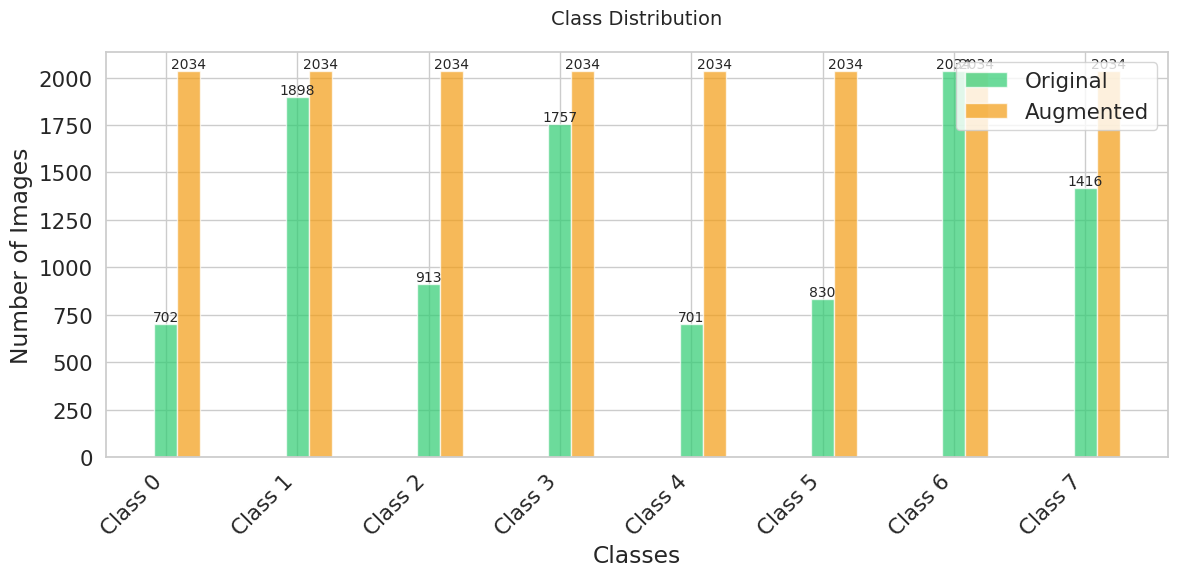

In [ ]:
# Plot with 2 datasets (train, val)
plot_class_distribution([y_train, y_train_augmented], class_names, ['Original', 'Augmented'])

Now the training dataset is balanced.

In [ ]:
display_images(X_augmented, y_augmented)

interactive(children=(Dropdown(description='Class Label', options=(None, 0, 1, 2, 3, 4, 5, 7), value=None), Ou…

In [ ]:
import numpy as np
from hashlib import sha256

def image_to_hash(image):
    """
    Convert an image to a hash for comparison.
    We use SHA-256 to generate a hash based on the image's flattened array.
    """
    # Flatten the image and encode it as bytes
    image_bytes = image.tobytes()

    # Generate the hash
    image_hash = sha256(image_bytes).hexdigest()

    return image_hash

def find_duplicate_images(X):
    """
    Find and return indices of duplicate images in an array of images X.

    Parameters:
        X (numpy.ndarray): Array of images with shape (num_images, height, width, channels)

    Returns:
        duplicate_indices (list): List of indices of duplicate images
    """
    # Store hashes of images to check for duplicates
    image_hashes = {}
    duplicate_indices = []

    # Loop through the images and hash each image
    for idx, image in enumerate(X):
        image_hash = image_to_hash(image)

        # Check if the hash is already in the dictionary
        if image_hash in image_hashes:
            # If it is, it's a duplicate, so store the index
            duplicate_indices.append(idx)
        else:
            # Otherwise, store the hash with the image's index
            image_hashes[image_hash] = idx

    return duplicate_indices

# Example usage with a dataset of images X
# Assuming X is a numpy array of shape (num_images, height, width, channels)
duplicate_indices = find_duplicate_images(X_train_augmented)

# Output duplicate indices
if duplicate_indices:
    print(f"Duplicate images found at indices: {duplicate_indices}")
else:
    print("No duplicates found.")

No duplicates found.


### Class Weights

In [ ]:
# Assuming y_train contains raw class labels
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train.ravel())
class_weights = dict(enumerate(class_weights))
print(class_weights)

{0: 1.8253205128205128, 1: 0.6751185458377239, 2: 1.4034775465498357, 3: 0.7292970973249858, 4: 1.8279243937232525, 5: 1.5438253012048193, 6: 0.6299778761061947, 7: 0.9049258474576272}


### Comparison

In order to test the data augmentation techniques exposed before we trained a vanilla CNN classifer using both techniques

In [ ]:
# Convert labels to categorical
y_train_augmented = tf.keras.utils.to_categorical(y_train_augmented, num_classes=len(np.unique(y_train_augmented)))
y_train = tf.keras.utils.to_categorical(y_train, num_classes=len(np.unique(y_train)))
y_val = tf.keras.utils.to_categorical(y_val, num_classes=len(np.unique(y_val)))

# Print shapes of the datasets
print(f"X_train shape: {X_train_augmented.shape}, y_train shape: {y_train_augmented.shape}")
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")

X_train shape: (16272, 96, 96, 3), y_train shape: (16272, 8)
X_train shape: (10251, 96, 96, 3), y_train shape: (10251, 8)
X_val shape: (1140, 96, 96, 3), y_val shape: (1140, 8)


In [ ]:
# Parameters
INPUT_SHAPE = X_train.shape[1:]
OUTPUT_SHAPE = y_train.shape[1]
BATCH_SIZE = 32
LEARNING_RATE = 1e-3
EPOCHS = 30

# Create an EarlyStopping callback
early_stopping = tfk.callbacks.EarlyStopping(
    monitor='val_F1Score',
    mode='max',
    patience=5,
    restore_best_weights=True
)

callbacks = [early_stopping]

print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_train dtype:", X_train.dtype)

print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)
print("y_train dtype:", y_train.dtype)

X_train shape: (10251, 96, 96, 3)
X_val shape: (1140, 96, 96, 3)
X_train dtype: uint8
y_train shape: (10251, 8)
y_val shape: (1140, 8)
y_train dtype: float64


In [ ]:
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomContrast, RandomBrightness
from tensorflow.keras.models import Model

# Define the CNN model using the Functional API
def create_model(input_shape, num_classes, layer_augmentation=False):
    # Input Layer
    inputs = tfkl.Input(shape=input_shape)
    if(layer_augmentation == True):
      x = RandomFlip(mode='horizontal_and_vertical')(inputs)
      x = RandomRotation(0.3)(x)
      x = RandomZoom(0.2)(x)
      x = RandomContrast(0.3)(x)
      x = RandomBrightness(0.1)(x)

    # First Convolutional Layer
    if(layer_augmentation == True):
      x = tfkl.Conv2D(32, (3, 3), activation='relu')(x)
    else :
      x = tfkl.Conv2D(32, (3, 3), activation='relu')(inputs)

    x = tfkl.MaxPooling2D((2, 2))(x)
    # Second Convolutional Layer
    x = tfkl.Conv2D(64, (3, 3), activation='relu')(x)
    x = tfkl.MaxPooling2D((2, 2))(x)

    # Third Convolutional Layer
    x = tfkl.Conv2D(128, (3, 3), activation='relu')(x)
    x = tfkl.MaxPooling2D((2, 2))(x)

    # Flatten the output from the convolutional layers
    x = tfkl.Flatten()(x)

    # Fully Connected (Dense) Layer
    x = tfkl.Dense(128, activation='relu')(x)

    # Output Layer
    outputs = tfkl.Dense(num_classes, activation='softmax')(x)  # For multi-class classification

    # Create the Model
    model = Model(inputs=inputs, outputs=outputs)

    # Compile the Model
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',  # Use 'binary_crossentropy' for binary classification
                  metrics=[tfk.metrics.F1Score(average='macro')])

    return model

# Create two identical models
model1 = create_model(INPUT_SHAPE, OUTPUT_SHAPE, True)
model2 = create_model(INPUT_SHAPE, OUTPUT_SHAPE, False)

# Display model summaries
model1.summary()
model2.summary()

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_16 (InputLayer)          │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_flip_6 (RandomFlip)           │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_rotation_6 (RandomRotation)   │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_zoom_6 (RandomZoom)           │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_contrast_6 (RandomContrast)   │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_brightness_6                  │ (None, 96, 96, 3)           │               0 │
│ (RandomBrightness)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_46 (Conv2D)                   │ (None, 94, 94, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_45 (MaxPooling2D)      │ (None, 47, 47, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_47 (Conv2D)                   │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_46 (MaxPooling2D)      │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_48 (Conv2D)                   │ (None, 20, 20, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_47 (MaxPooling2D)      │ (None, 10, 10, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_15 (Flatten)                 │ (None, 12800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ (None, 128)                 │       1,638,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_31 (Dense)                     │ (None, 8)                   │           1,032 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,732,808 (6.61 MB)

 Trainable params: 1,732,808 (6.61 MB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_17 (InputLayer)          │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_49 (Conv2D)                   │ (None, 94, 94, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_48 (MaxPooling2D)      │ (None, 47, 47, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_50 (Conv2D)                   │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_49 (MaxPooling2D)      │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_51 (Conv2D)                   │ (None, 20, 20, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_50 (MaxPooling2D)      │ (None, 10, 10, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_16 (Flatten)                 │ (None, 12800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_32 (Dense)                     │ (None, 128)                 │       1,638,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_33 (Dense)                     │ (None, 8)                   │           1,032 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,732,808 (6.61 MB)

 Trainable params: 1,732,808 (6.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the model with synthetic data
history2 = model2.fit(
    x=X_train_augmented,
    y=y_train_augmented,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val, y_val),
    callbacks=callbacks
).history

# Calculate and print the final validation F1Score
final_val_F1Score2 = round(max(history2['val_f1_score'])* 100, 2)
print(f'Final f1score : {final_val_F1Score2}%')

# Save the trained model to a file with the F1Score included in the filename
model_filename2 = 'MNV3_synth_.keras'
model2.save(model_filename2)

# Delete the model to free up resources
del model2

Final validation accuracy: 94.87%


In [ ]:
# Train the model with eclass weights
history1 = model1.fit(
    x=X_train,
    y=y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    class_weight=class_weights
).history

# Calculate and print the final validation accuracy
final_val_F1Score1 = round(max(history1['val_f1_score'])* 100, 2)
print(f'Final validation F1Score: {final_val_F1Score1}%')

# Save the trained model to a file with the accuracy included in the filename
model_filename1 = 'MNV3_weights_.keras'
model1.save(model_filename1)

# Delete the model to free up resources
del model1

Epoch 1/30
321/321 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - f1_score: 0.4242 - loss: 12.7103 - val_f1_score: 0.5886 - val_loss: 1.0085
Epoch 2/30
321/321 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - f1_score: 0.6669 - loss: 0.8658 - val_f1_score: 0.7938 - val_loss: 0.4812
Epoch 3/30
321/321 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - f1_score: 0.7444 - loss: 0.6595 - val_f1_score: 0.8473 - val_loss: 0.4016
Epoch 4/30
321/321 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - f1_score: 0.7984 - loss: 0.5336 - val_f1_score: 0.8656 - val_loss: 0.3589
Epoch 5/30
321/321 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - f1_score: 0.8263 - loss: 0.4503 - val_f1_score: 0.9007 - val_loss: 0.2734
Epoch 6/30
321/321 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - f1_score: 0.8514 - loss: 0.3993 - val_f1_score: 0.8781 - val_loss: 0.3353
Epoch 7/30
321/321 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - f1_score: 0.8544 - loss: 0.3847 - val_f1_score: 0.8862 - val_loss: 0.2936
Epoch 8/30
321/321 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - f1_score: 0.8435 - loss: 0.4098 - val_f1

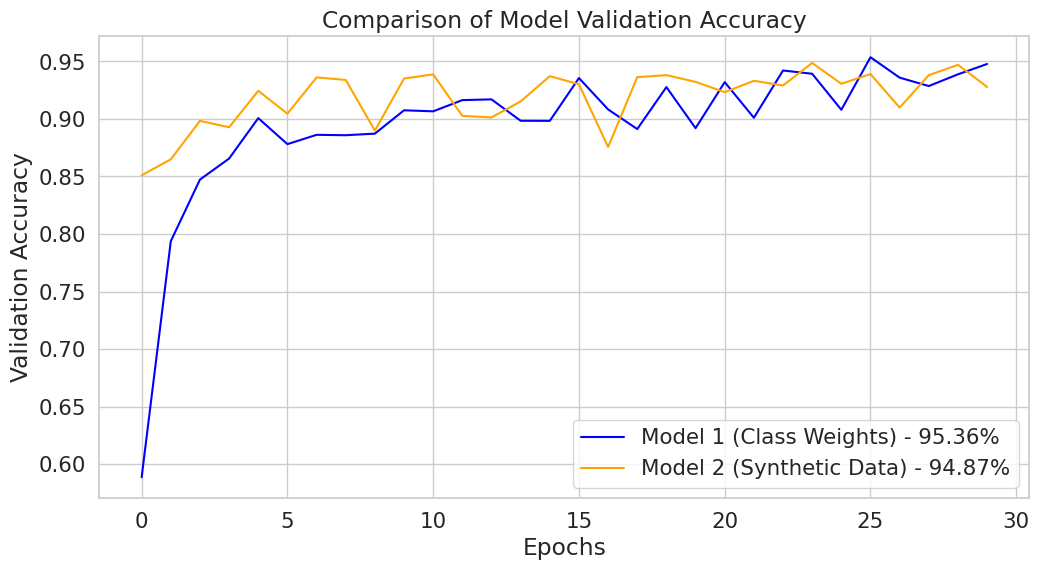

In [ ]:
# Plot comparison of validation accuracy for both models
plt.figure(figsize=(12, 6))
plt.plot(history1['val_f1_score'], label=f'Model 1 (Class Weights) - {final_val_F1Score1}%', color='blue')
plt.plot(history2['val_f1_score'], label=f'Model 2 (Synthetic Data) - {final_val_F1Score2}%', color='orange')
plt.title('Comparison of Model Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Load model1 and model2 if necessary (if models were deleted after training)
model1 = tf.keras.models.load_model(model_filename1)
model2 = tf.keras.models.load_model(model_filename2)

# Make predictions for model1 on the test set
y_pred1 = np.argmax(model1.predict(X_test), axis=-1)
y_pred2 = np.argmax(model2.predict(X_test), axis=-1)

# Calculate and display test set accuracy
print('SYNTHETIC---------------------------')
test_accuracy = accuracy_score(y_test, y_pred2)
print(f'Accuracy score over the test set: {round(test_accuracy, 4)}')
test_precision = precision_score(y_test, y_pred2, average='weighted')
print(f'Precision score over the test set: {round(test_precision, 4)}')
test_recall = recall_score(y_test, y_pred2, average='weighted')
print(f'Recall score over the test set: {round(test_recall, 4)}')
test_f1 = f1_score(y_test, y_pred2, average='weighted')
print(f'F1 score over the test set: {round(test_f1, 4)}')
print('WEIGHTS---------------------------')
test_accuracy = accuracy_score(y_test, y_pred1)
print(f'Accuracy score over the test set: {round(test_accuracy, 4)}')
test_precision = precision_score(y_test, y_pred1, average='weighted')
print(f'Precision score over the test set: {round(test_precision, 4)}')
test_recall = recall_score(y_test, y_pred1, average='weighted')
print(f'Recall score over the test set: {round(test_recall, 4)}')
test_f1 = f1_score(y_test, y_pred1, average='weighted')
print(f'F1 score over the test set: {round(test_f1, 4)}')

# Compute confusion matrices for both models
cm1 = confusion_matrix(y_test, y_pred1)
cm2 = confusion_matrix(y_test, y_pred2)

# Plot confusion matrices side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

# Plot confusion matrix for model1
sns.heatmap(cm1, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
axes[0].set_title(f'Model 1 (Class Weights)\nConfusion Matrix')
axes[0].set_xlabel('Predicted Labels')
axes[0].set_ylabel('True Labels')

# Plot confusion matrix for model2
sns.heatmap(cm2, annot=True, fmt='d', cmap='Oranges', ax=axes[1],
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
axes[1].set_title(f'Model 2 (Synthetic Data)\nConfusion Matrix')
axes[1].set_xlabel('Predicted Labels')
axes[1].set_ylabel('True Labels')

plt.tight_layout()
plt.show()

# Optionally, you can delete the models to free up resources
del model1
del model2

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
SYNTHETIC---------------------------
Accuracy score over the test set: 0.9214
Precision score over the test set: 0.9334
Recall score over the test set: 0.9214
F1 score over the test set: 0.9231
WEIGHTS---------------------------
Accuracy score over the test set: 0.9679
Precision score over the test set: 0.968
Recall score over the test set: 0.9679
F1 score over the test set: 0.9678


KeyboardInterrupt: 

Using classes weights and training time data augmentation gave slightly best results in the test set, hence we are going to use this approach for each model.

In [ ]:
#save Correctly preprocessed Train, Validation and Test set
np.savez('preprocessed_dataset.npz', X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, X_test=X_test, y_test=y_test)